# Wildfire Smoke Controls on Gross Primary Production in Central Canada

## Part 1: Data Scrubbing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# show full dataframes
pd.set_option('max_columns', None)

# for temporarily displaying function output
from IPython.display import clear_output

%run ./drf_stats.ipynb

In [2]:
# get data
data_in = pd.read_csv("drf_timeseries.csv", parse_dates=True, index_col=1).drop("Unnamed: 0", axis=1)

### Select only the relevant months

This study is really only concerned with what goes on between May and September, as the vast majority of primary production (trees photosynthesizing/consuming CO2) and wildfire activity happen in the summer

In [3]:
# select just the growing/wildfire season (may-sept, inclusive)
growing_season = pd.DataFrame()
for month in [5,6,7,8,9]:
    growing_season = growing_season.append(data_in[data_in.index.month == month])

# make sure the data stays in order by date
growing_season = growing_season.sort_values(by="datetime")
growing_season

,smoke,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,AOD_620nm,AOD_560nm,AOD_555nm,AOD_551nm,AOD_532nm,AOD_531nm,AOD_510nm,AOD_500nm,AOD_490nm,AOD_443nm,AOD_440nm,AOD_412nm,AOD_400nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),AOD_681nm,AOD_709nm,Ozone(Dobson),NO2(Dobson),USTAR,TA,WD,WS,NEE_PI,FC,SC,H,SH,LE,SLE,G,TS_1,TS_2,P,RH,PA,CO2_1,CO2_2,VPD_PI,SWC_1,SWC_2,NETRAD,PPFD_IN,SW_IN,SW_DIF,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,RECO_PI,APAR,PPFD_DIF,FAPAR,ZL
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-08-05 00:00:00,0.0,NaN,0.043281,0.050140,NaN,NaN,0.056433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077186,NaN,NaN,0.084066,NaN,NaN,0.095379,0.109326,0.503352,NaN,NaN,377.728603,0.155769,NaN,16.754,238.260,2.5785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.5670,10.3795,0.0,61.7660,94.6780,NaN,NaN,0.7295,NaN,NaN,-38.485,0.000,0.06,NaN,0.000,0.105,335.240,373.680,NaN,NaN,NaN,1.6125,NaN,NaN
2005-08-05 01:00:00,0.0,NaN,0.041713,0.049306,NaN,NaN,0.055380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077047,NaN,NaN,0.083923,NaN,NaN,0.094999,0.110109,0.510514,NaN,NaN,377.707512,0.155787,NaN,16.437,238.760,1.8935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.2685,10.1695,0.0,60.0260,94.6620,NaN,NaN,0.7475,NaN,NaN,-35.440,-0.005,0.19,NaN,0.000,-0.005,334.600,370.220,NaN,NaN,NaN,1.5790,NaN,NaN
2005-08-05 02:00:00,0.0,NaN,0.037905,0.045268,NaN,NaN,0.050330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070703,NaN,NaN,0.075927,NaN,NaN,0.086224,0.100517,0.493424,NaN,NaN,377.680050,0.155811,NaN,16.347,248.315,2.3990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.9970,9.9720,0.0,59.3995,94.6285,NaN,NaN,0.7550,17.0,27.47,-30.630,0.000,0.35,NaN,0.000,-0.045,337.985,369.005,NaN,NaN,NaN,1.6050,NaN,NaN
2005-08-05 03:00:00,0.0,NaN,0.034070,0.040381,NaN,NaN,0.044884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063583,NaN,NaN,0.067235,NaN,NaN,0.077404,0.091669,0.470614,NaN,NaN,377.652588,0.155835,NaN,16.077,252.895,1.8860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.7580,9.7935,0.0,60.1995,94.5740,NaN,NaN,0.7275,NaN,NaN,-45.005,0.000,0.00,NaN,0.000,-0.120,320.270,365.400,NaN,NaN,NaN,1.5550,NaN,NaN
2005-08-05 04:00:00,0.0,NaN,0.032243,0.038891,NaN,NaN,0.043012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060868,NaN,NaN,0.063953,NaN,NaN,0.075606,0.089504,0.507524,NaN,NaN,377.623732,0.155859,NaN,15.396,232.210,0.8960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5185,9.6225,0.0,60.8120,94.5105,NaN,NaN,0.6855,NaN,NaN,-46.400,0.160,-0.02,NaN,0.005,-0.290,314.705,361.375,NaN,NaN,NaN,1.8040,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-14 19:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 20:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 21:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Find which measurements have the most complete data

In [4]:
check_complete(growing_season)

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_865nm:  0.0 %
AOD_779nm:  0.0 %
AOD_675nm:  6.44 %
AOD_667nm:  0.0 %
AOD_620nm:  0.0 %
AOD_560nm:  0.0 %
AOD_555nm:  0.0 %
AOD_551nm:  0.0 %
AOD_532nm:  0.0 %
AOD_531nm:  0.0 %
AOD_510nm:  0.0 %
AOD_500nm:  5.51 %
AOD_490nm:  0.0 %
AOD_443nm:  0.0 %
AOD_440nm:  6.32 %
AOD_412nm:  0.0 %
AOD_400nm:  0.0 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
AOD_681nm:  0.0 %
AOD_709nm:  0.0 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
SH:  0.0 %
LE:  34.41 %
SLE:  0.0 %
G:  0.0 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
SW_DIF:  0.0 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
RECO_PI:  4.32 %
AP

Pretty dismal. We need the AOD data, so set a cutoff at 5%. Hopefully we can interpolate the rest

In [5]:
data = keep_complete(growing_season, 5.0)
check_complete(data) # see if that worked

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_675nm:  6.44 %
AOD_500nm:  5.51 %
AOD_440nm:  6.32 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
LE:  34.41 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
PPFD_DIF:  34.87 %


### Interpolation

Now, go through each individual measurement and hand-tune the pandas interpolation scheme to come up with something realistic (If this can't be achieved, toss the whole column). There is a balance here, we are trying to maximize coverage where all columns are finite (not NaNs, so we can perform PCA on as big of dataset as possible), without dangerously extending data beyond what is physical.

#### AOD Data

Physical intuition tells us that smoke events operate on a scale of hours to weeks. We can maybe therefore safely interpolate out to several days before getting into trouble

In [6]:
# get all the AOD columns that survived the purge
aod_list = []
for key in data.keys():
    if "AOD" in key:
        aod_list.append(key)
        print(key)

AOD_1640nm
AOD_1020nm
AOD_870nm
AOD_675nm
AOD_500nm
AOD_440nm
AOD_380nm
AOD_340nm


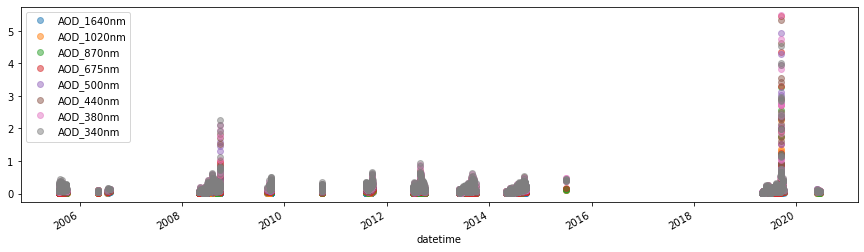

In [7]:
# peek at the raw AOD data. How big of gaps am I willing to try to fill?
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

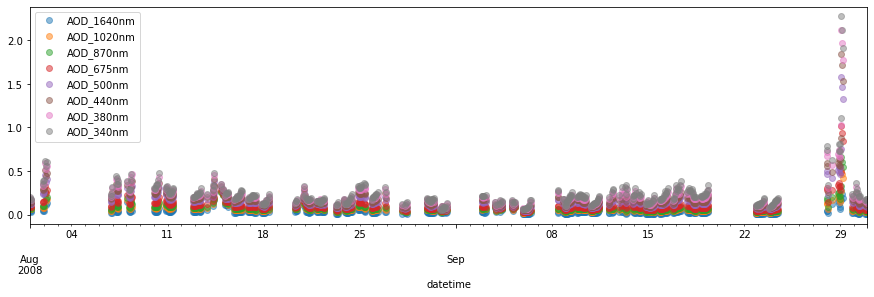

In [8]:
# enhance...
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list]['2008-08-01':'2008-09-30'].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

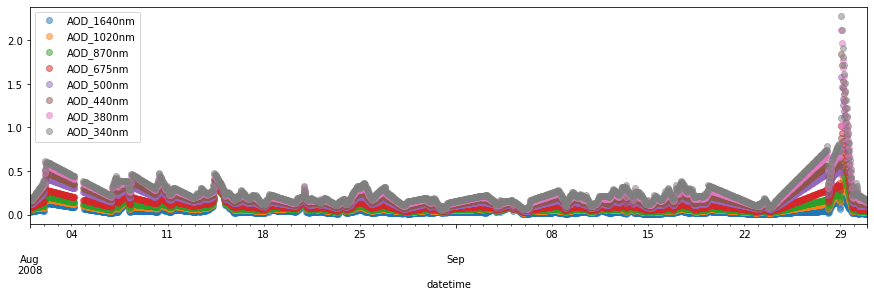

In [9]:
# interpolate with a limit of 48 hour gaps between real data points
data[aod_list] = data[aod_list].interpolate(method='time', limit=48, limit_direction='both')

# re-plot
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list]['2008-08-01':'2008-09-30'].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

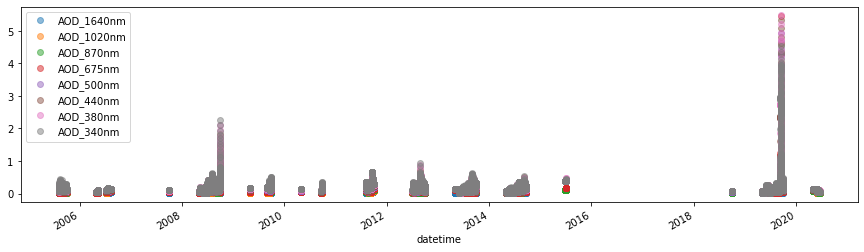

In [10]:
# zoom out again
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

In [11]:
# how much did that help?
check_complete(data[aod_list])

AOD_1640nm:  31.0 %
AOD_1020nm:  35.14 %
AOD_870nm:  36.0 %
AOD_675nm:  35.91 %
AOD_500nm:  31.1 %
AOD_440nm:  35.2 %
AOD_380nm:  36.0 %
AOD_340nm:  35.92 %


48 hours of interpolation will massively increase the amount of viable data (remember, we can't perform PCA on data where *any* of the elements are NaN) while maintaining some sort of realism. What we are implicitly saying here is that we can expect whatever smoke/pollutant/synoptic weather pattern to persist with a timescale of $\approx$ 48 hours (or at least we hope so).

#### Other AERONET Data

- `Precipitable_Water(cm)` total precipitable water in the column
- `Ozone(Dobson)`          calculated ozone concentration
- `NO2(Dobson)`            calculated nitrogen dioxide concentration

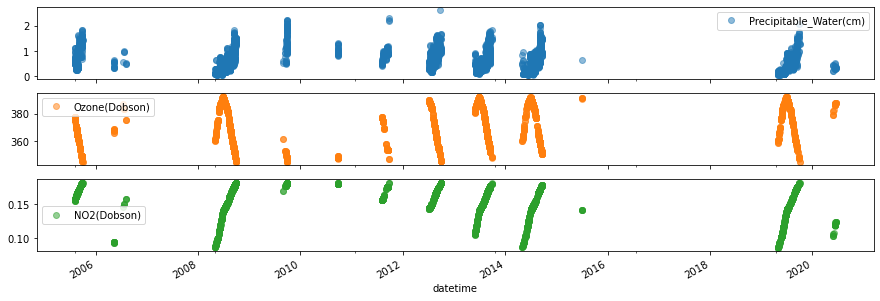

In [12]:
# handle these three much like AOD data above
aeronet = ["Precipitable_Water(cm)", "Ozone(Dobson)", "NO2(Dobson)"]

#fig, ax = plt.subplots(figsize=(15,4))
data[aeronet].plot(marker='o', linestyle="none", alpha=0.5, subplots=True, figsize=(15,5));

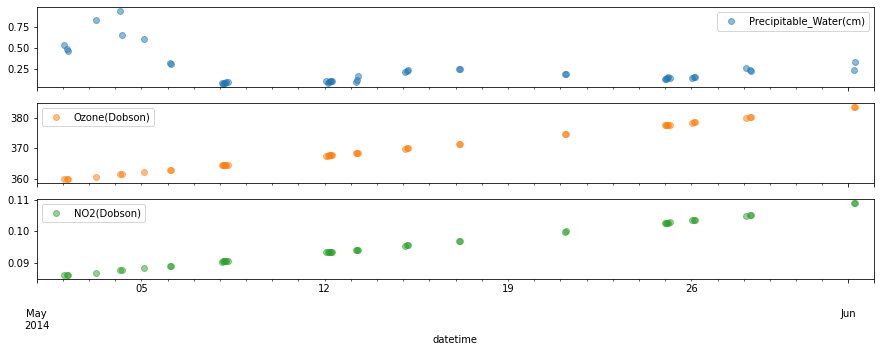

In [13]:
# zoom in on a period of interest (a dense-looking period)
data[aeronet]['2014-05-01':'2014-06-01'].plot(marker='o',
                                              linestyle="none", 
                                              alpha=0.5,
                                              subplots=True, 
                                              figsize=(15,5));

Ozone episodes and precipitable water tend to be regional in scale (Mckendry 1993) and depend on both synoptic and boundary layer meteorology, as well as precursor concentrations (often supplied by wildfires). NO2 is somewhat similar (see Seinfeld and Pandis). Use the same 48 hr interpolation limit as with AOD. (Note: AERONET stations take data several times daily, I'm not sure why this data is so sparse..)

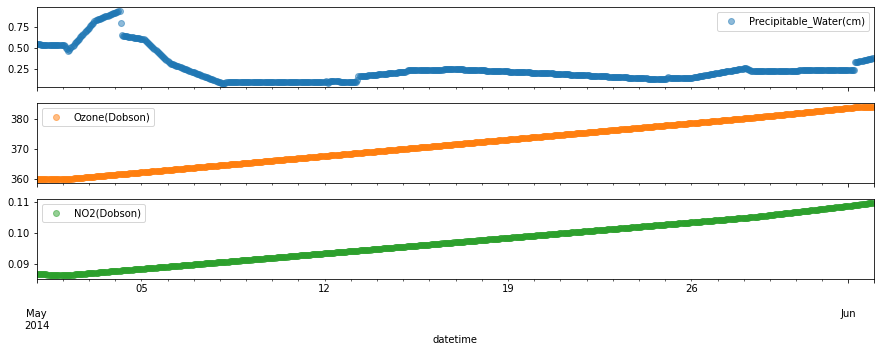

In [14]:
# interpolate with a limit of 48 hour gaps between real data points
data[aeronet] = data[aeronet].interpolate(method='time', limit=48, limit_direction='both')

# re-plot
data[aeronet]['2014-05-01':'2014-06-01'].plot(marker='o',
                                                linestyle="none", 
                                                alpha=0.5,
                                                subplots=True, 
                                                figsize=(15,5));

In [15]:
# check data completeness after interpolation
check_complete(data[aeronet])

Precipitable_Water(cm):  35.91 %
Ozone(Dobson):  36.0 %
NO2(Dobson):  36.0 %


### More Interpolated Variables 

(move on for now)

### Assemble the Final Dataset

In [16]:
# after we finish messing about with interpolations, drop all rows that still have missing data
data_complete = data.dropna()
data_complete

,smoke,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_675nm,AOD_500nm,AOD_440nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),Ozone(Dobson),NO2(Dobson),USTAR,TA,WD,WS,NEE_PI,FC,SC,H,LE,TS_1,TS_2,P,RH,PA,CO2_1,CO2_2,VPD_PI,SWC_1,SWC_2,NETRAD,PPFD_IN,SW_IN,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,PPFD_DIF
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-09-29 06:00:00,0.0,0.024802,0.039233,0.045199,0.053805,0.070111,0.078917,0.091111,0.096388,0.350353,364.987069,0.110711,0.3730,8.4910,350.570,3.1740,7.0590,5.5330,0.6650,-40.5000,1.4265,7.1695,7.2140,0.0,81.4295,93.0645,399.85,400.80,0.2070,19.37,32.801,-10.0150,0.390,1.145,-0.025,-0.005,342.230,353.395,9.5050,0.2590
2007-09-29 10:00:00,0.0,0.024792,0.039221,0.045186,0.053794,0.070100,0.078906,0.091097,0.096369,0.350300,364.983070,0.110692,0.9965,8.1105,342.435,6.3670,-5.7805,-5.2700,-0.5100,131.3000,27.4100,6.8630,6.9430,0.0,85.5990,93.2375,390.80,391.20,0.1560,19.16,32.530,197.2300,550.345,251.120,24.265,21.895,331.980,363.975,9.7890,466.1100
2007-09-29 18:00:00,0.0,0.024772,0.039197,0.045160,0.053772,0.070078,0.078885,0.091071,0.096330,0.350195,364.975072,0.110654,0.5070,4.3960,330.825,4.0575,1.3440,1.4360,-0.0915,-34.6300,10.7730,7.1165,7.1590,0.0,92.2775,93.8190,383.05,383.75,0.0655,20.36,32.970,-19.6750,34.955,23.330,2.105,3.805,300.820,340.020,8.1695,26.7740
2007-09-29 22:00:00,0.0,0.024762,0.039186,0.045147,0.053761,0.070067,0.078874,0.091057,0.096311,0.350142,364.971073,0.110635,0.2515,2.6745,318.795,3.0290,2.1190,1.0605,0.1870,-31.3050,-3.1390,6.7620,6.9025,0.0,91.6660,94.0490,386.85,387.75,0.0625,20.67,33.220,-73.9550,0.005,0.090,0.030,0.120,254.145,328.065,7.0650,0.1510
2007-09-30 10:00:00,0.0,0.024732,0.039150,0.045107,0.053727,0.070034,0.078842,0.091018,0.096253,0.349984,364.959077,0.110578,0.3270,4.2680,252.975,1.8390,-2.3960,-2.0400,-0.3555,50.6850,118.7650,5.3620,5.8430,0.0,76.8005,94.4990,379.65,380.45,0.1935,20.90,33.520,277.6200,811.575,410.330,42.610,37.535,244.440,339.620,6.4250,195.3350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-01 18:00:00,0.0,0.033652,0.032546,0.040330,0.052824,0.082452,0.098096,0.119279,0.129015,1.348858,347.481642,0.180454,0.9730,6.4765,47.350,7.0945,0.9255,0.7855,0.1405,-21.3125,22.1550,0.7795,0.1720,0.0,55.8875,93.0315,393.35,392.00,0.4270,27.33,32.980,-7.0250,42.785,17.050,0.970,0.750,329.830,352.800,5.6455,39.9280
2010-05-01 22:00:00,0.0,0.033621,0.032528,0.040309,0.052798,0.082413,0.098049,0.119220,0.128948,1.348251,347.483668,0.180453,0.8770,4.5510,44.975,5.9395,1.7530,1.7190,0.0340,-29.6150,16.1000,0.6585,0.1500,0.0,66.0370,93.3590,394.05,392.70,0.2880,27.41,33.070,-17.2950,0.000,0.140,0.010,-0.040,326.240,343.715,5.8395,0.1380
2010-05-02 02:00:00,0.0,0.033590,0.032509,0.040288,0.052772,0.082374,0.098002,0.119161,0.128881,1.347643,347.485694,0.180452,0.4810,2.4680,35.785,3.6775,1.0770,1.0440,0.0340,-36.6550,2.3575,0.4805,0.1145,0.0,72.1790,93.5485,394.40,393.55,0.2040,27.48,33.170,-64.7700,0.000,-0.455,-0.005,0.020,267.215,331.510,5.4915,0.1435


In [17]:
#######################################################
### choose which version of the dataset to use here ###
#######################################################

data = data_complete

## Part 2: Perform PCA On the Dataset

Now that we have a somewhat complete (at least a bit less gappy) dataset, we can turn back to the question at hand. How big of a role does wildfire smoke play in determining the CO2 fluxes near a forest canopy? 

The basic workflow is:

1) Group by smoke level to generate 4 dataframes

2) Split off outputs (carbon flux data) from the inputs and do PCA on the inputs

3) Look at the PCs of each regime and compare

In [18]:
# Split the dataset by smoke level, and perform the analysis individually for each
smoke_lvl = data.groupby("smoke")

smoke_dict = {}
for key, value in smoke_lvl:
    smoke_dict[key] = value

### Control Case: No Smoke

It appears that almost all the variance is contained in the first mode. For the sake of it, lets use the first 4

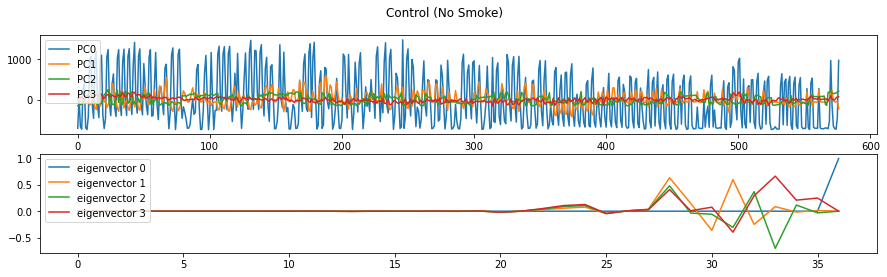

In [25]:
eigvecs0, PCs0, outputs0 = do_PCA(smoke_dict[0.0], "Control (No Smoke)")

analysis

### Case 2: Light Smoke

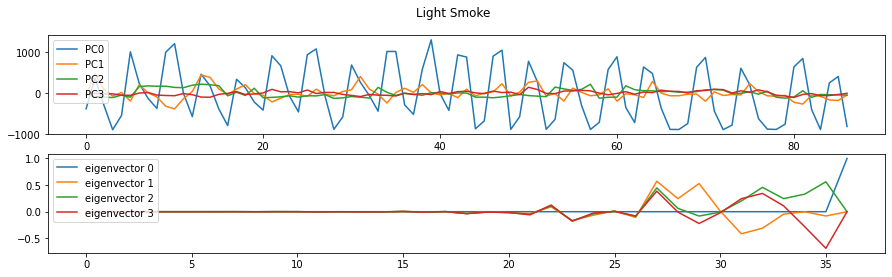

In [26]:
eigvecs1, PCs1, outputs1 = do_PCA(smoke_dict[5.0], "Light Smoke")

#### Analysis

mode 1 is unchanged, but the others are not! So under light smokey conditions, the dynamics governing CO2 uptake (this function specifically describes NEE - net ecosystem exchange) are somewhat different! Hopefully these are not just random statistical fluctuations...

## Part 3: MLR with the PCs



=== MLR Coefficients ===
PC0: -8.52635768055499
PC1: -5.146787499429389
PC2: 0.5585479014448874
PC3: 1.5608517324749482


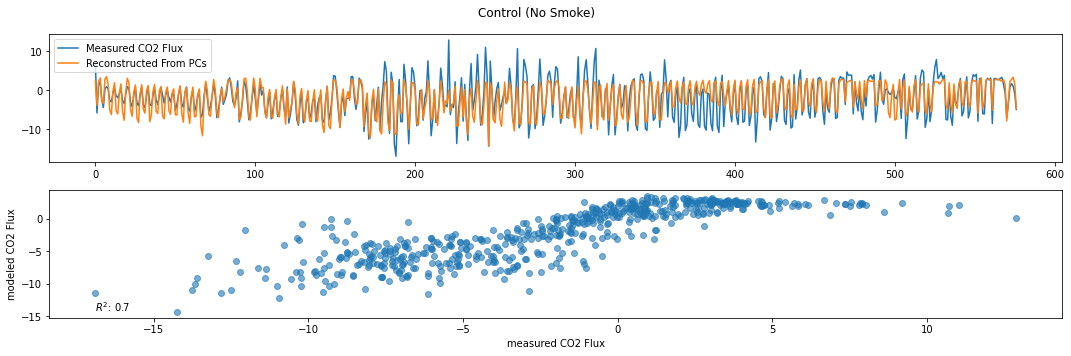

In [23]:
# do MLR on the non-smoke control case
do_MLR(PCs0, outputs0, "Control (No Smoke)", 4)

=== MLR Coefficients ===
PC0: -7.831399817594558
PC1: -4.444650187317544
PC2: 0.23316805538083163
PC3: 1.7065630166163677


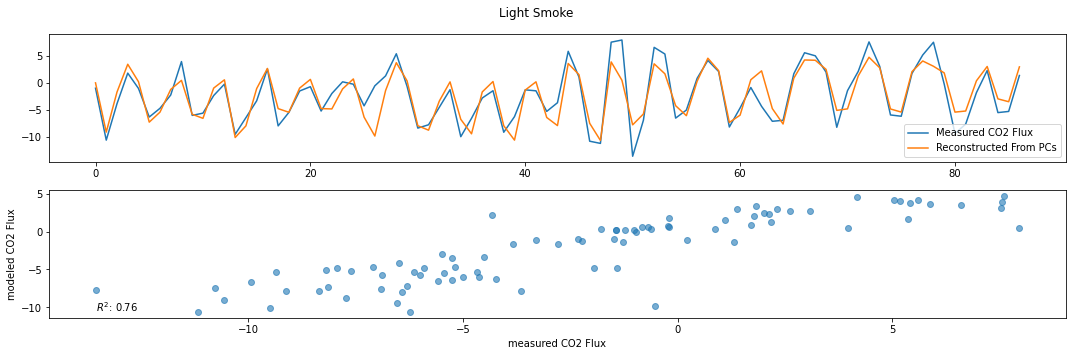

In [24]:
# do MLR on the light smoke case
do_MLR(PCs1, outputs1, "Light Smoke",4)

## To Do

- Interpolate all columns, eyeball-optimizing between coverage and faithful interpolated values
- chop out dates and outputs, perform PCA on everything else
- try step 2 again, this time grouping on smoke level. Are the leading modes different?


- Try it again with rotated PCA
- Write up the presentation
